# Feature Selection Methods and Feature Selection Curves

How to Select the Best Features for Machine Learning!

Let’s deep dive into several feature selection techniques and help you
figure out when to use each one. The notebook includes two data sources:
the MNIST dataset and the Madelon dataset. The MNIST dataset is a
collection of 28x28 pixel images of handwritten digits. The Madelon
dataset is a synthetic dataset that you can control.

The notebook uses the following feature selection techniques:

-   F-statistic
-   Mutual Information
-   Logistic Regression
-   Logistics Regression with Lasso (L1) Regularization
-   Feature Importance
-   Boruta
-   MRMR (Minimum Redundancy Maximum Relevance)
-   Recursive Feature Elimination
-   Feature importance rank ensembling (FIRE)

To help visualize the feature selection process, the notebook includes a
feature selection curve. The feature selection curve plots the number of
features against the accuracy of the model. This helps you understand
how many features you need to achieve a certain level of accuracy.

This notebook is based on the following articles:  
[Feature Selection: How to Throw Away 95% of Your Features and Get 95%
Accuracy](https://towardsdatascience.com/feature-selection-how-to-throw-away-95-of-your-data-and-get-95-accuracy-ad41ca016877)
and the associated
[notebook](https://github.com/smazzanti/mrmr/blob/15cb0983a3e53114bbab94a9629e404c1d42f5d8/notebooks/mnist.ipynb).

A companion video to this can be found on my youtube site, @rajistics:
[Feature Selection Methods and Feature Selection
Curves](https://youtu.be/jm7TYGv32zs), it’s about 15 minutes and gives
more context to the notebook.

This blog post can be found at http://bit.ly/raj_fs or
https://projects.rajivshah.com/blog/Feature_Selection.html

In [2]:
import warnings; warnings.filterwarnings("ignore")

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import pandas as pd
import matplotlib.pyplot as plt

# Import data

### A. MNIST (Very visual dataset)

In [25]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)

In [ ]:
print(list(X_train[7, :]))

In [ ]:
plt.imshow(X_train[7, :].reshape(28, 28), cmap = 'binary', vmin = 0, vmax = 255)
plt.xticks([])
plt.yticks([])
plt.savefig('sample_image.png')

In [6]:
X_train = pd.DataFrame(X_train)  # Assuming X_mnist is the MNIST feature data
y_train = pd.Series(y_train)   
X_test = pd.DataFrame(X_test)  # Assuming X_mnist is the MNIST feature data
y_test = pd.Series(y_test)  

### B. Madelon (Very high-dimensional dataset that you control)

If you run the following cells, Madelon will be the dataset you use. If
you want to use MNIST, you should skip the following cells.

Madelon is a favorite of mine because you know which features are
carrying the signal and which ones are noise. In this case, the first 5
features will be informative. I often modify Madelon to include other
types of noisy features, interactions, correlations, and then use this
dataset to test various machine learning techniques. Since I know what
the true signal is, this is very effective at helping me guage the
effectiveness of these methods.

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000,
                           n_features=40,
                           n_informative=5,
                           n_classes=3,
                           n_redundant = 3,
                           random_state=0,
                           flip_y =0.05,
                           class_sep = 0.5,
                           n_clusters_per_class=3,
                           shuffle=False)

X_df = pd.DataFrame(X, columns=[f'{i}' for i in range(X.shape[1])])
y_df = pd.Series(y, name='target')

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)


In [4]:
X_train

8000 rows × 40 columns

# Feature selection

Let’s go through a couple of different methods for feature selection

# Feature Selection Methods Comparison

| Method | Pros | Cons | Best Used When | Computational Complexity |
|----------|--------|--------|-------------------|-----------------------------|
| F-statistic | \- Fast and simple<br>- Works well for linear relationships<br>- Easy to interpret | \- Assumes linear relationship<br>- Considers features independently<br>- May miss interaction effects | \- Initial screening<br>- Linear problems<br>- Need interpretable results | O(n) |
| Mutual Information | \- Captures non-linear relationships<br>- No assumptions about distribution | \- Can be computationally intensive<br>- May overfit with small samples | \- Non-linear relationships<br>- Complex interactions | O(n log n) |
| Logistic Regression | \- Fast for high-dimensional data<br>- Provides feature coefficients | \- Assumes linear decision boundary<br>- Sensitive to correlated features | \- Binary classification<br>- Need interpretable coefficients | O(n^2) |
| Lasso (L1) | \- Fast for high-dimensional data<br>- Automatically does feature selection | \- May struggle with correlated features<br>- Can be sensitive to outliers | \- High-dimensional data<br>- Need sparse solutions | O(n^2) |
| LightGBM | \- Handles non-linear relationships<br>- Considers feature interactions | \- Can be computationally intensive<br>- May overfit with small samples | \- Complex relationships<br>- Large datasets | O(n log n) |
| MRMR | \- Considers feature redundancy<br>- Good for correlated features | \- Can be computationally intensive<br>- May struggle with non-linear relationships | \- Datasets with correlated features<br>- Need diverse feature set | O(n^2) |
| RFE | \- Considers feature interactions<br>- Can capture complex relationships | \- Computationally intensive<br>- Can be unstable with small changes in data | \- When computational cost isn’t an issue<br>- Need very precise feature selection | O(n^2 log n) |

### 1. F-statistic

f_classif relies on the Analysis of Variance (ANOVA) F-statistic to
evaluate the relationship between each feature and the target variable.
It tests whether the mean values of the target variable differ
significantly across the groups defined by each feature. The higher the
F-value, the more likely it is that the feature discriminates between
different classes. Assumes a linear relationship between the features
and the target, and that the target is categorical.

See:
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [5]:
from sklearn.feature_selection import f_classif

f = f_classif(X_train, y_train)[0]
f

array([2.40810399e+02, 6.64390517e+01, 5.42587843e+01, 1.71099993e-01,
       4.27226542e+01, 9.64735668e+01, 4.72136845e+01, 5.71846457e+01,
       1.27834979e+00, 1.42650284e+00, 3.40020422e-01, 4.08232233e-01,
       1.30120819e-01, 3.36734714e+00, 4.55665866e-01, 3.62300510e-01,
       1.57485437e-01, 6.93572687e-02, 1.64816305e+00, 2.91782944e+00,
       1.24026934e+00, 9.32533895e-01, 7.07099908e-01, 1.87544216e+00,
       1.10130690e+00, 3.54044700e-01, 1.15417945e+00, 2.59156089e-01,
       7.45820681e-01, 7.75403854e-01, 1.35835715e-01, 3.34985292e+00,
       8.36576456e-02, 5.15026453e-02, 4.33788709e-01, 3.12140721e-01,
       3.55118575e+00, 7.37076241e+00, 1.17274619e+00, 4.36532461e+00])

### 2. Mutual information

mutual_info_classif uses the concept of mutual information, which
measures the dependency between each feature and the target variable.
Mutual information quantifies the amount of information gained about the
target by knowing the value of the feature. It captures both linear and
non-linear dependencies.

See:
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [6]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train)
mi

array([0.05548077, 0.01340894, 0.04092611, 0.00099355, 0.00516085,
       0.06952759, 0.02752171, 0.04043945, 0.00083431, 0.        ,
       0.        , 0.        , 0.        , 0.01146672, 0.        ,
       0.00298292, 0.        , 0.        , 0.0068234 , 0.00961735,
       0.00935105, 0.00586449, 0.00561433, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00876386, 0.00049355,
       0.        , 0.00478042, 0.00487523, 0.00268551, 0.00118896,
       0.        , 0.00583264, 0.        , 0.        , 0.        ])

### 3. Logistic regression

Logistic regression is a linear model for classification rather than
regression. It is used to estimate the probability that an instance
belongs to a particular class. The coefficients of the model can be used
to determine feature importance.

In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)
logreg.coef_

array([[-0.08669758,  0.06064912, -0.04063592,  0.00704782,  0.05079063,
        -0.02366404, -0.03246196, -0.07613473, -0.02216845,  0.00405511,
         0.00890925, -0.01289459, -0.00446435,  0.00330386,  0.01287983,
        -0.00599418,  0.00494212, -0.00385749,  0.03721175, -0.03849129,
        -0.0032749 , -0.01534965, -0.00908255,  0.02016669, -0.00175419,
         0.00918138,  0.01908963,  0.01357562, -0.01804835,  0.00266229,
         0.00180036, -0.00624841, -0.00351875,  0.00131487, -0.01573702,
        -0.00485053, -0.03744854,  0.05047984,  0.0174477 , -0.00658735],
       [ 0.22615114, -0.09497312, -0.04870109,  0.08462927, -0.00434942,
         0.0845374 ,  0.05186658,  0.05312074,  0.01121456,  0.0271935 ,
        -0.00027397,  0.01737956,  0.0080553 , -0.04770429, -0.00379082,
        -0.00963934,  0.00274429,  0.00688572, -0.03159925,  0.02737958,
        -0.0220797 , -0.00789503, -0.01134082, -0.02724488, -0.02432216,
         0.00543336, -0.02498671, -0.00919296,  0.

### 3.5 Feature Selection with L1 (Lasso) Regularization

Lasso is a great feature selection technique. It’s fast, easy to use,
and works well with high-dimensional data. I have often used it when
very wide data, greater than 100 features (or even \>10k features) to
help parse down the number of features. It uses L1 regularization to
penalize the absolute size of the coefficients. This leads to sparse
solutions, where many of the coefficients are zero. The features with
non-zero coefficients are selected. Lasso can be used for feature
selection by setting the regularization parameter to a value that
results in a sparse solution. The regularization parameter can be tuned
using cross-validation.

Try modifying the regularization parameter to see how it affects the
number of features selected.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Step 4: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Apply Logistic Regression with L1 regularization for feature selection
logregL1 = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', C=0.01)  # C is inverse of regularization strength
logregL1.fit(X_train_scaled, y_train)

# Step 6: Get the selected features using the original DataFrame 'X'
selected_features = X_train.columns[(logregL1.coef_ != 0).any(axis=0)]
print("Selected features: ", selected_features)

# Optional: Check the coefficients
#print("Logistic Regression coefficients: ", logreg.coef_)

Selected features:  Index([0, 1, 2, 4, 5, 13, 19, 36, 37], dtype='int64')

### 4. LightGBM

LightGBM is a gradient boosting framework that uses tree-based learning
algorithms. It is designed for efficiency and can handle large datasets.
It can be used to determine feature importance.

In [9]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    objective = 'multiclass',
    metric = 'multi_logloss',
    importance_type = 'gain'
).fit(X_train, y_train)

lgbm.feature_importances_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 40
[LightGBM] [Info] Start training from score -1.108284
[LightGBM] [Info] Start training from score -1.094371
[LightGBM] [Info] Start training from score -1.093252

array([7030.24782425, 4036.90086633, 7197.39050466, 5339.74033117,
       2017.793881  , 8113.67321557, 3905.26838762, 4383.72206521,
        550.03625131,  531.02187729,  472.12624365,  678.28547454,
        526.57803982,  586.75292325,  552.92263156,  433.08122051,
        552.18078488,  534.15573859,  566.58704376,  630.01932001,
        635.43262064,  636.71719581,  560.95981157,  586.52648336,
        553.7755444 ,  563.13766581,  547.99060541,  523.01072556,
        676.76891661,  616.94216621,  634.27822083,  489.91742009,
        680.71264285,  620.95509708,  618.59545827,  418.22946733,
        568.21738124,  592.29172051,  553.43465978,  655.03435677])

### 5. Boruta

Boruta is an all-relevant feature selection method. It is an extension
of the Random Forest algorithm. It selects all features that are
relevant to the target variable, rather than just the most important
features.

In [10]:
### long training time > 1 hour
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

#boruta = BorutaPy(
#    estimator = RandomForestClassifier(max_depth = 5), 
#    n_estimators = 'auto', 
#    max_iter = 100
#).fit(X_train, y_train)

### 6. MRMR

MRMR (Minimum Redundancy Maximum Relevance) is a feature selection
method that selects features based on their relevance to the target
variable and their redundancy with other features. It aims to select
features that are highly correlated with the target variable but
uncorrelated with each other.

There are several implementations of MRMR available in Python:
https://github.com/smazzanti/mrmr
https://koaning.github.io/scikit-lego/api/feature-selection/
https://github.com/AutoViML/featurewiz?tab=readme-ov-file

In [11]:
import pandas as pd
from mrmr import mrmr_classif

#mrmr = mrmr_classif(pd.DataFrame(X_train), pd.Series(y_train), K = 784)
mrmr = mrmr_classif(pd.DataFrame(X_train), pd.Series(y_train), K = X_train.shape[1])

100%|██████████| 40/40 [00:03<00:00, 11.45it/s]

### Store results

In [12]:
import numpy as np

ranking = pd.DataFrame(index = range(X_train.shape[1]))

ranking['f'] = pd.Series(f, index = ranking.index).fillna(0).rank(ascending = False)
ranking['mi'] = pd.Series(mi, index = ranking.index).fillna(0).rank(ascending = False)
ranking['logreg'] = pd.Series(np.abs(logreg.coef_).mean(axis = 0), index = ranking.index).rank(ascending = False)
ranking['lasso']= pd.Series(np.abs(logregL1.coef_).mean(axis = 0), index = ranking.index).rank(ascending = False)
ranking['lightgbm'] = pd.Series(lgbm.feature_importances_, index = ranking.index).rank(ascending = False)
#ranking['boruta'] = boruta.support_* 1 + boruta.support_weak_ * 2 + (1 - boruta.support_ - boruta.support_weak_) * X_train.shape[1]
ranking['mrmr'] = pd.Series(
    list(range(1, len(mrmr) + 1)) + [len(mrmr) + 1] * (X_train.shape[1] - len(mrmr)),
    index = mrmr + list(set(ranking.index) - set(mrmr))
).sort_index()
ranking['lasso']= pd.Series(np.abs(logregL1.coef_).mean(axis = 0), index = ranking.index).rank(ascending = False)


ranking = ranking.replace(to_replace = ranking.max(), value = X_train.shape[1])
#ranking.to_csv('ranking.csv', index = False)

# Evaluate Feature Selection Methods

Let’s see how the predictive performance of the model changes as we add
more features. We will use the top features selected by each method to
train a model and evaluate its performance.

In [13]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
## 22 minutes for mnist

algos = ['f', 'mi', 'logreg', 'lasso', 'lightgbm', 'mrmr'] ##Feel free to change this
ks = [1, 2, 5, 10, 15, 20, 30, 40] 
ks = [1, 2, 3, 5, 10, 20, 30, 40] ##Feel free to change this

accuracy = pd.DataFrame(index = ks, columns = algos)
roc = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
    print (algo)
    for k in ks:
    
        cols = ranking[algo].sort_values().head(k).index.to_list()
                
        clf = CatBoostClassifier().fit(
            X_train[cols], y_train,
            eval_set=(X_test[cols], y_test),
            early_stopping_rounds = 20,
            verbose = False
        )
                
        # Store accuracy
        accuracy.loc[k, algo] = accuracy_score(
            y_true=y_test, y_pred=clf.predict(X_test[cols])
        )
        
accuracy.to_csv('accuracyMC.csv', index = True)
roc.to_csv('rocMC.csv', index = True)

f
mi
logreg
lasso
lightgbm
mrmr

# Feature Selection Curves

Let’s visualize how the model’s accuracy changes as a function of
feature selection.  
Notice how for Madelon, there is an optimal number of features. Too many
features that are noise end up reducing the performance of the model

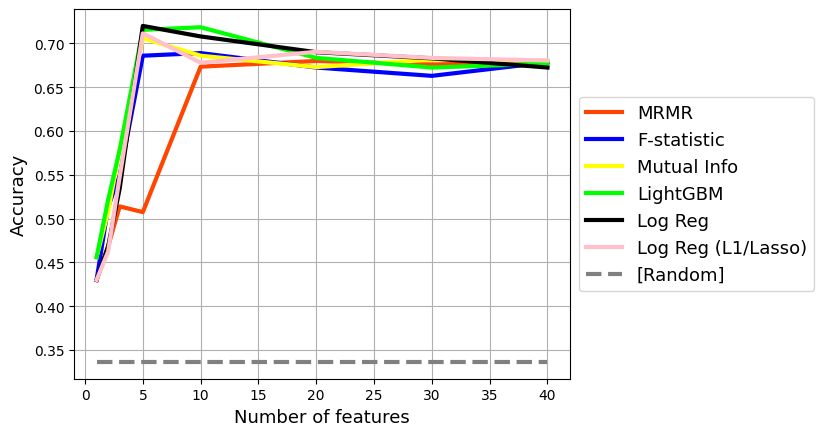

In [14]:
for algo, label, color in zip(
    ['mrmr', 'f', 'mi', 'lightgbm', 'logreg',"lasso"],
    ['MRMR', 'F-statistic', 'Mutual Info', 'LightGBM', 'Log Reg','Log Reg (L1/Lasso)'],
    ['orangered', 'blue', 'yellow', 'lime', 'black', 'pink']):
        plt.plot(accuracy.index, accuracy[algo], label = label, color = color, lw = 3)

plt.plot(
    [1, 40], [pd.Series(y_test).value_counts(normalize = True).iloc[0]] * 2, 
    label = '[Random]', color = 'grey', ls = '--', lw = 3
)

plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid()
plt.xlabel('Number of features', fontsize = 13)
plt.ylabel('Accuracy', fontsize = 13)
plt.savefig('accuracy.png', dpi = 300, bbox_inches = 'tight')

# Feature Selection combined with Feature Elimination Techniques

### Recursive Feature Elimination

One of the best methods for feature selection consistently is feature
importance with LightGBM. We can refine and improve this in several
ways: Recursive Feature Elimination uses the same feature importance
method, but then iteratively removes the least important features. This
iterative process requires training a model several times, but can
provide an improvement in feature selection. This method is a version of
Recursive Feature Elimination that is widely accepted as a best practice
for feature selection.

In [15]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.svm import SVR
model = XGBClassifier(random_state=42)
#model = SVR(kernel="linear")  #took 3 minutes, ok results but not as good as XGB on Madelon
rfe = RFE(model, n_features_to_select=7, step=1)
#rfe = RFE(model, n_features_to_select=50, step=200,verbose=2) #for MNIST
rfe.fit(X_train, y_train)
rfe.support_

array([ True,  True,  True,  True, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [16]:
# Train an XGBoost model with the selected features from RFE
model_selected = XGBClassifier(random_state=42)
X_selected = X_train.loc[:, rfe.support_]
model_selected.fit(X_selected, y_train)

# Make predictions on the test set with both models
y_pred_selected = model_selected.predict(X_test.loc[:, rfe.support_])
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy with selected features: {accuracy_selected:.4f}")

Accuracy with selected features: 0.7135

Compare with perfect on Madelon

In [17]:
perfect = [ True,  True,  True,  True, True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False]

In [18]:
# Train an XGBoost model with the selected features from RFE
model_selected = XGBClassifier(random_state=42)
X_selected = X_train.loc[:, perfect]
model_selected.fit(X_selected, y_train)

# Make predictions on the test set with both models
y_pred_selected = model_selected.predict(X_test.loc[:, perfect])
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy with selected features: {accuracy_selected:.4f}")

Accuracy with selected features: 0.7140

### Feature Elimination with FIRE

At DataRobot, we had a mighty AutoML engine that showed you how feature
importance aggregated across different models (this is feature
importance from four diverse models).
![](https://docs.datarobot.com/en/docs/images/fire-2.png)

You can use this variance as part of feature selection. It takes a lot
more compute, but in our experiments, can perform even better feature
selection. Read more about feature importance rank ensembling (FIRE)
here -
https://docs.datarobot.com/en/docs/api/accelerators/adv-approaches/fire.html
and a code snippet is here -
https://github.com/datarobot-community/examples-for-data-scientists/blob/master/Feature%20Lists%20Manipulation/Python/Advanced%20Feature%20Selection.ipynb

### FeatureViz

Featureviz looks like a cool feature selection package, but I wasn’t
able to get it to work. It’s worth checking out. add links

# Other great feature selection resources:

A classic dataset where many feature selection techniques have been
applied is the [Kaggle Santader Customer
Satisfaction](https://www.kaggle.com/competitions/santander-customer-satisfaction)
competition.

[Feature Selection with Feature
Engine](https://www.kaggle.com/code/solegalli/feature-selection-with-feature-engine/notebook)

[Advance Feature Selection
Tutorial](https://www.kaggle.com/code/adarshsng/extensive-advance-feature-selection-tutorial)